In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [21]:
spy = yf.Ticker("SPY")
df = spy.history(period='max', interval='1d')[['Open', 'High', 'Low', 'Close']]

In [22]:
df['Return'] = df['Close'].pct_change()

In [23]:
def getWeights_FFD(d, thres):
    """
    Compute the weights for Fractional Differencing using the Fixed-Width Window method.

    This function calculates the weights required for fractional differencing based on the 
    parameter `d`. The weights decrease in magnitude as the function iterates and stops 
    when the absolute value of the next weight falls below a specified threshold (`thres`).

    Args:
    - d (float): The fractional differencing parameter. Determines the strength of differencing.
    - thres (float): Threshold for the smallest weight to include. Iteration stops when the 
      next weight is smaller than this threshold.

    Returns:
    - np.ndarray: Array of fractional differencing weights, arranged in reverse order.
    """
    w, k = [1.], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)


def fracDiff_FFD(series, d, thres=1e-5):
    """
    Apply Fractional Differencing with Fixed-Width Window on a time series to make it stationary.

    Fractional differencing aims to remove long-term dependence from time series data while 
    preserving memory in the data. This method uses a fixed-width window and calculates the 
    fractional differences using the precomputed weights.

    Args:
    - series (pd.DataFrame): Time series data (columns represent individual time series) to be fractionally differenced.
    - d (float): The fractional differencing parameter. Determines the strength of differencing.
    - thres (float, optional): Threshold for the smallest weight to include. Default is 1e-5.

    Returns:
    - pd.DataFrame: A DataFrame with the same structure as `series`, containing the fractionally differenced series.
    """
    # Get fractional differencing weights using the provided threshold and d value
    w, df = getWeights_FFD(d, thres), {}
    width = len(w) - 1
    
    # Apply fractional differencing to each column in the DataFrame
    for name in series.columns:
        # Forward fill to handle missing data and create a new series for results
        seriesF = series[[name]].ffill().dropna()
        df_ = pd.Series(index=series.index, dtype=float)
        
        # Loop through the series and apply the fractional differencing weights
        for iloc in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc - width], seriesF.index[iloc]
            if not np.isfinite(series.loc[loc1, name]):
                continue
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        
        # Store the fractionally differenced column in the result dictionary
        df[name] = df_.copy(deep=True)
    
    # Combine all columns into a DataFrame
    df = pd.concat(df, axis=1)
    
    return df

In [24]:
df['0.25_return'] = fracDiff_FFD(df['Close'].to_frame(), d=0.25)
df['0.5_return'] = fracDiff_FFD(df['Close'].to_frame(), d=0.5)
df['0.75_return'] = fracDiff_FFD(df['Close'].to_frame(), d=0.75)

<Axes: xlabel='Date'>

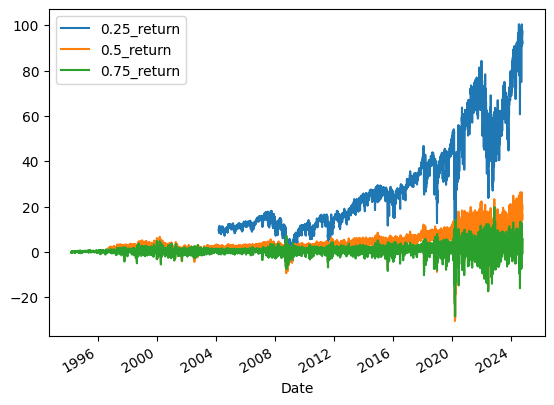

In [34]:
df[['0.25_return', '0.5_return', '0.75_return']].plot()